In [1]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric._kernel_base import gpke
from statsmodels.nonparametric.kernels import gaussian, aitchison_aitken
from statsmodels.nonparametric.kernel_regression import KernelReg
from py_kernel_regression import loc_constant_fit, fit_predict

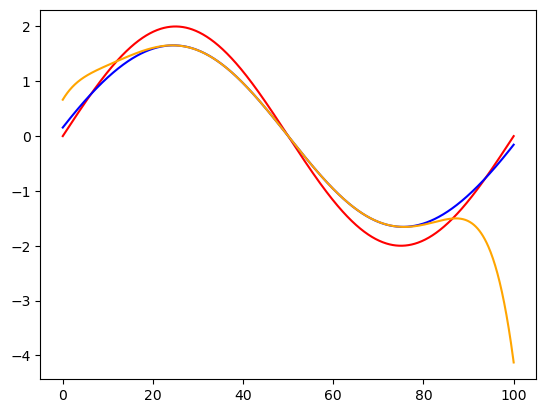

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
n = 1000
x = np.linspace(0, 100, n)
y = np.array([2.0 * np.sin(x_i * np.pi/50) for x_i in x])

exog = x[:, None] 
endog = y[:, None]

mod = sm.nonparametric.KernelReg(endog, exog, var_type='c', reg_type='ll', bw=[10.0])

y_hat = mod.fit()[0]

y_hat_rust = fit_predict([10.0], endog.ravel(), exog, exog, var_type=["c"], reg_type="loc_linear")

plt.plot(x, y, color="red")
plt.plot(x, y_hat, color="blue")
plt.plot(x, y_hat_rust, color="orange")


In [7]:
data_endog

NameError: name 'data_endog' is not defined